In [3]:
import pandas as pd
import numpy as np
import re
import requests
from bs4 import BeautifulSoup
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from datasets import load_dataset
import nltk
from nltk.tokenize import sent_tokenize
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
import seaborn as sns

In [14]:
!sudo apt-get update
!sudo apt-get install openjdk-17-jdk -y

Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Get:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:3 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:5 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Get:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [1,384 kB]
Get:7 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Hit:8 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Get:9 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:11 http://security.ubuntu.com/ubuntu jammy-security/main amd64 Packages [2,788 kB]
Get:12 https://r2u.stat.illinois.edu/ubuntu jammy/main amd64 Packages [2,697 kB]
Hit:13 http://archive.ubuntu.com/ubu

In [15]:
!sudo update-alternatives --install /usr/bin/java java /usr/lib/jvm/java-17-openjdk-amd64/bin/java 1
!sudo update-alternatives --set java /usr/lib/jvm/java-17-openjdk-amd64/bin/java

update-alternatives: using /usr/lib/jvm/java-11-openjdk-amd64/bin/java to provide /usr/bin/java (java) in auto mode
update-alternatives: using /usr/lib/jvm/java-17-openjdk-amd64/bin/java to provide /usr/bin/java (java) in manual mode


In [4]:
!pip install language_tool_python
!pip install datasets
!pip install nltk
!pip install beautifulsoup4
!pip install lxml[html_clean]

In [32]:
from nltk.corpus import stopwords
import language_tool_python

nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')

stop_words = set(stopwords.words('english'))
def remove_stopwords(text):
    if pd.isna(text) or text == "":
        return ""
    words = nltk.word_tokenize(text)
    filtered_words = [word for word in words if word.lower() not in stop_words]
    return " ".join(filtered_words)

dataset = load_dataset('sergioburdisso/news_media_reliability')
reliability_df = pd.DataFrame(dataset['train'])
print(f"Columns: {reliability_df.columns.tolist()}")
# COLUMNS OF THIS DATASET:
#domain: domain name,
#reliability_label: the reliability label ( 1: generally reliable; 0: mixed; -1: generally unreliable)
#newsguard_score: human-provided reliability score (only available for a small subset). Value: integer number between 0 and 100.
source_reliability = dict(zip(reliability_df['domain'], reliability_df['reliability_label']))


fake_news_dataset = load_dataset("ErfanMoosaviMonazzah/fake-news-detection-dataset-English")
news_df = pd.DataFrame(fake_news_dataset['train'])

print("Dataset loaded successfully!")
print(f"Columns: {news_df.columns.tolist()}")
print(f"Label distribution: {news_df['label'].value_counts().to_dict()}")


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Columns: ['domain', 'reliability_label', 'newsguard_score']
Dataset loaded successfully!
Columns: ['Unnamed: 0', 'title', 'text', 'subject', 'date', 'label']
Label distribution: {0: 15478, 1: 14522}


In [33]:
# language tool for grammar checking
language_tool = language_tool_python.LanguageTool('en-US')

news_df['text'] = news_df['text'].apply(remove_stopwords)
reliability_df['text'] = reliability_df['domain'].apply(remove_stopwords)

In [34]:
def extract_domain(url):
    if pd.isna(url):
        return None
    try:
        match = re.search(r'https?://(?:www\.)?([^/]+)', url)
        if match:
            return match.group(1)
        return None
    except:
        return None

def calculate_grammar_score(text):
    if pd.isna(text) or text.strip() == "":
        text = "This article may lack content or failed to load properly."

    try:
        sample_text = str(text)[:5000]
        errors = language_tool.check(sample_text)
        word_count = len(sample_text.split())

        if word_count == 0:
            return 60

        error_rate = (len(errors) / word_count) * 100
        base_score = 100 - error_rate

        penalty = 0.8 if error_rate > 10 else 1.0
        score = max(20, base_score * penalty)
        return score
    except:
        return 60
def excessive_punctuation_score(text):
    if pd.isna(text) or text.strip() == "":
        text = "This article may lack content or failed to load properly."

    text = str(text)
    total_chars = len(text)

    if total_chars == 0:
        return 60

    punctuation_count = sum(1 for char in text if char in '.,!?;:\'"-()[]{}')
    punctuation_ratio = punctuation_count / total_chars

    raw_score = 100 - (punctuation_ratio * 500)

    if punctuation_ratio > 0.1:
        score = raw_score * 0.85
    else:
        score = raw_score

    return max(20, min(score, 100))


def get_source_reliability_score(domain):
    if domain is None:
        return 50

    if domain in source_reliability:
        rel_label = source_reliability[domain]
        if rel_label == 1:
            return 90
        elif rel_label == 0:
            return 50
        else:
            return 10
    else:
        return 50

def fetch_article_content(url):
    try:
        headers = {
            'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'
        }
        response = requests.get(url, headers=headers, timeout=10)
        response.raise_for_status()

        soup = BeautifulSoup(response.text, 'html.parser')
        title = soup.title.text.strip() if soup.title else ""

        for script in soup(["script", "style"]):
            script.decompose()

        paragraphs = soup.find_all('p')
        text = ' '.join([p.text.strip() for p in paragraphs])

        return {
            'title': title,
            'text': text
        }
    except Exception as e:
        print(f"Error fetching article: {e}")
        return {'title': "", 'text': ""}

In [35]:
news_df = news_df.dropna(subset=['text'])

X = news_df['text'].values
y = news_df['label'].values

print("Label distribution:")
print(pd.Series(y).value_counts())

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

vectorizer = TfidfVectorizer(max_features=1000, stop_words='english')
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)


content_classifier = RandomForestClassifier(
    n_estimators=100,
    max_depth=20,
    min_samples_split=10,
    min_samples_leaf=5,
    random_state=42
)



content_classifier.fit(X_train_vec, y_train)

y_pred = content_classifier.predict(X_test_vec)
print("Content Classifier Performance:")
print(classification_report(y_test, y_pred))
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")

Label distribution:
0    15478
1    14522
Name: count, dtype: int64
Content Classifier Performance:
              precision    recall  f1-score   support

           0       0.98      0.95      0.97      3096
           1       0.95      0.98      0.97      2904

    accuracy                           0.97      6000
   macro avg       0.97      0.97      0.97      6000
weighted avg       0.97      0.97      0.97      6000

Accuracy: 0.9677


In [36]:
def analyze_news_article(url):
    try:
        domain = extract_domain(url)

        article_content = fetch_article_content(url)
        text = article_content['text']
        title = article_content['title']

        grammar_score = calculate_grammar_score(text)
        punctuation_score = excessive_punctuation_score(text)
        source_score = get_source_reliability_score(domain)

        if len(text) > 0:
            text_vec = vectorizer.transform([text])
            content_pred_proba = content_classifier.predict_proba(text_vec)[0]
            real_class_idx = list(content_classifier.classes_).index(1) if 1 in content_classifier.classes_ else 0
            content_score = content_pred_proba[real_class_idx] * 100
        else:
            content_score = 50

        overall_score = (
            source_score * 0.45 +
            content_score * 0.2 +
            grammar_score * 0.2 +
            punctuation_score * 0.15
        )

        results = {
            'url': url,
            'domain': domain,
            'title': title,
            'source_reliability_score': source_score,
            'content_credibility_score': content_score,
            'grammar_score': grammar_score,
            'punctuation_score': punctuation_score,
            'overall_credibility_score': overall_score,
            'credibility_rating': get_credibility_rating(overall_score)
        }

        return results

    except Exception as e:
        print(f"Error analyzing article: {e}")
        return None

def get_credibility_rating(score):
    if score >= 80:
        return "Highly Credible"
    elif score >= 65:
        return "Mostly Credible"
    elif score >= 50:
        return "Somewhat Credible"
    elif score >= 35:
        return "Questionable"
    else:
        return "Low Credibility"

def visualize_credibility_analysis(results):
    if results is None:
        print("No results to visualize")
        return

    scores = {
        'Source Reliability': results['source_reliability_score'],
        'Content Analysis': results['content_credibility_score'],
        'Grammar Quality': results['grammar_score'],
        'Punctuation': results['punctuation_score'],
        'Overall': results['overall_credibility_score']
    }

    plt.figure(figsize=(10, 6))
    sns.barplot(x=list(scores.keys()), y=list(scores.values()))
    plt.title(f"News Credibility Analysis: {results['credibility_rating']}")
    plt.ylim(0, 100)
    plt.axhline(y=50, color='red', linestyle='--', alpha=0.5)
    plt.ylabel('Score (0-100)')
    plt.tight_layout()
    plt.show()

    print(f"\nArticle: {results['title']}")
    print(f"Source: {results['domain']}")
    print(f"Overall Credibility: {results['overall_credibility_score']:.1f}/100 ({results['credibility_rating']})")
    print("\nComponent Scores:")
    for component, score in scores.items():
        if component != 'Overall':
            print(f"- {component}: {score:.1f}/100")


Analyzing: https://www.reuters.com/world/us/trump-pick-jd-vance-gop-vice-presidential-nominee-2024-07-15/
Error fetching article: 401 Client Error: HTTP Forbidden for url: https://www.reuters.com/world/us/trump-pick-jd-vance-gop-vice-presidential-nominee-2024-07-15/


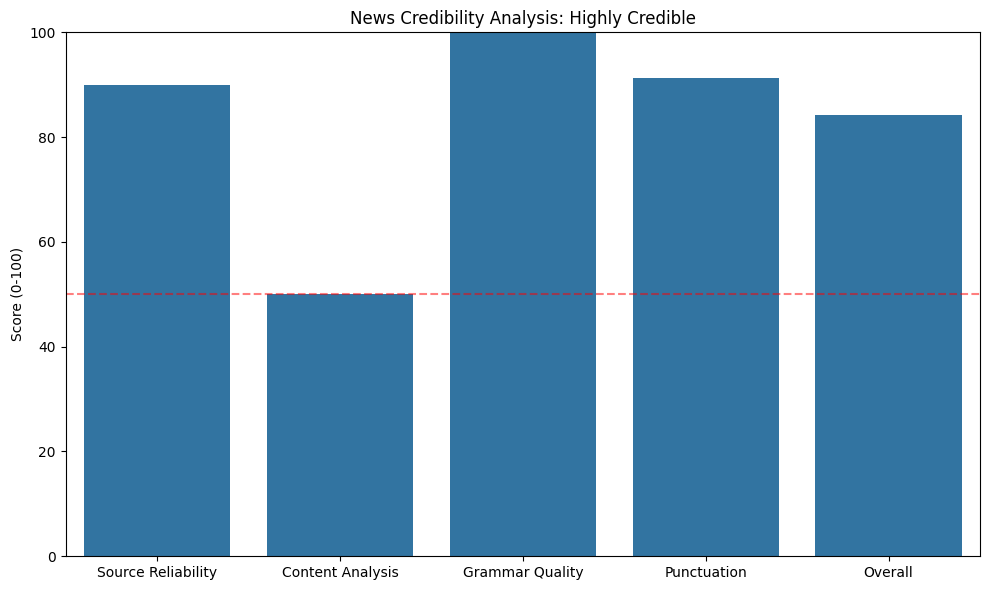


Article: 
Source: reuters.com
Overall Credibility: 84.2/100 (Highly Credible)

Component Scores:
- Source Reliability: 90.0/100
- Content Analysis: 50.0/100
- Grammar Quality: 100.0/100
- Punctuation: 91.2/100

Analyzing: https://www.bbc.com/news/world-us-canada-66913892
Error fetching article: 404 Client Error: Not Found for url: https://www.bbc.com/news/world-us-canada-66913892


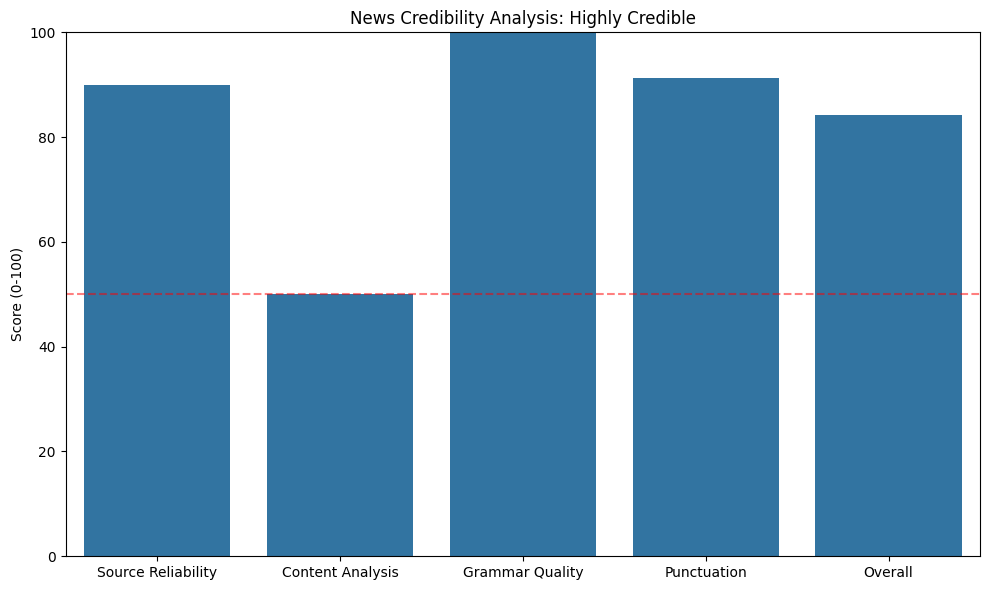


Article: 
Source: bbc.com
Overall Credibility: 84.2/100 (Highly Credible)

Component Scores:
- Source Reliability: 90.0/100
- Content Analysis: 50.0/100
- Grammar Quality: 100.0/100
- Punctuation: 91.2/100

Analyzing: https://www.theonion.com/report-nobody-cares-about-thing-you-re-about-to-post-1850294785
Error fetching article: 404 Client Error: Not Found for url: https://theonion.com/report-nobody-cares-about-thing-you-re-about-to-post-1850294785


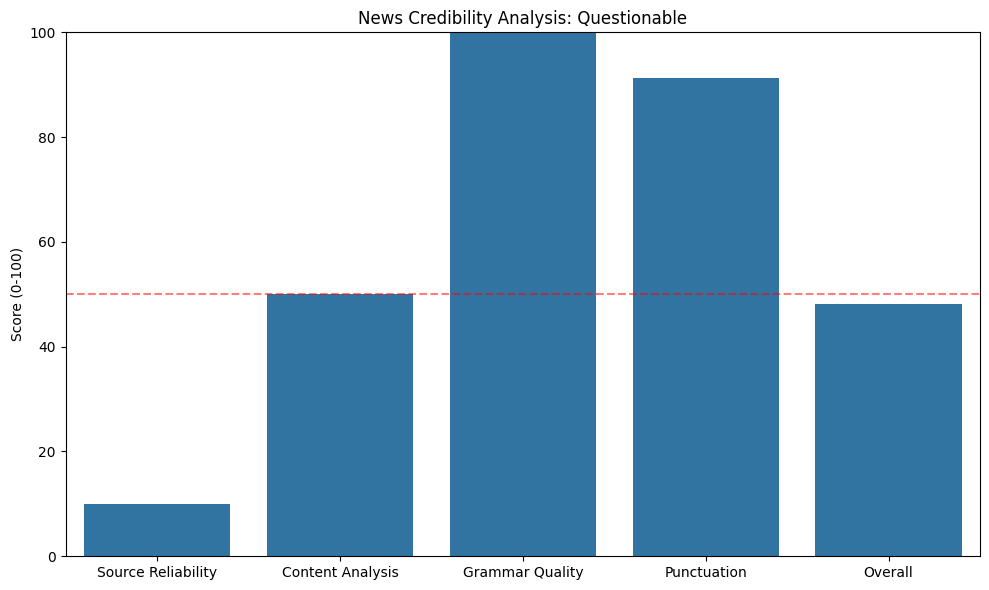


Article: 
Source: theonion.com
Overall Credibility: 48.2/100 (Questionable)

Component Scores:
- Source Reliability: 10.0/100
- Content Analysis: 50.0/100
- Grammar Quality: 100.0/100
- Punctuation: 91.2/100


In [37]:
test_urls = [
    "https://www.reuters.com/world/us/trump-pick-jd-vance-gop-vice-presidential-nominee-2024-07-15/",
    "https://www.bbc.com/news/world-us-canada-66913892",
    "https://www.theonion.com/report-nobody-cares-about-thing-you-re-about-to-post-1850294785"
]

for url in test_urls:
    print("\n" + "="*50)
    print(f"Analyzing: {url}")
    results = analyze_news_article(url)
    visualize_credibility_analysis(results)